# Time series Predictions of COVID-19 stats

In [ ]:
!pip install pmdarima

In [2]:
import pmdarima as pm
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit
import pandas as pd
import numpy as np
import datetime
import requests
import warnings

import matplotlib.pyplot as plt
import matplotlib
import matplotlib.dates as mdates
import matplotlib.ticker as ticker

import seaborn as sns

from sklearn.model_selection import train_test_split
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA
from sklearn.preprocessing import StandardScaler
from fbprophet import Prophet
from fbprophet.plot import plot_plotly, add_changepoints_to_plot

import itertools
import statsmodels.api as sm

from tensorflow.keras.optimizers import Adam

warnings.filterwarnings('ignore')


# Get the data and prepare the dataset data frame

In [3]:
path = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
df = pd.read_csv(path)

df.sample(4)

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,...,12/28/20,12/29/20,12/30/20,12/31/20,1/1/21,1/2/21,1/3/21,1/4/21,1/5/21,1/6/21,1/7/21,1/8/21,1/9/21,1/10/21,1/11/21,1/12/21,1/13/21,1/14/21,1/15/21,1/16/21,1/17/21,1/18/21,1/19/21,1/20/21,1/21/21,1/22/21,1/23/21,1/24/21,1/25/21,1/26/21,1/27/21,1/28/21,1/29/21,1/30/21,1/31/21,2/1/21,2/2/21,2/3/21,2/4/21,2/5/21
58,Anhui,China,31.825700,117.226400,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,3,4,4,5,6,6,6,6,6,6,6,6,6,6,6,6,6,...,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6
47,Nova Scotia,Canada,44.682000,-63.744300,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,65,65,65,65,65,65,65,65,65,65,65,65,65,65,65,65,65,65,65,65,65,65,65,65,65,65,65,65,65,65,65,65,65,65,65,65,65,65,65,65
41,Diamond Princess,Canada,0.000000,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
133,NaN,Germany,51.165691,10.451526,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,31145,32267,33230,33791,34145,34480,34791,35748,36757,37835,38987,40022,40597,40936,41799,42889,44096,45207,45705,46464,46901,47263,48997,50010,50876,51713,51873,52296,53127,53619,54498,55883,56286,57105,57163,58059,58992,59776,60634,61324


In [4]:
daily_df = df.loc[:, '1/22/20':].T
daily_df.sample(4)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272
4/25/20,47,27,419,40,2,3,185,28,3,33,0,6,4,10,16,8,536,21,11,8,140,6,67,6917,2,1,0,46,57,1,4057,1,55,41,5,1,1,0,53,73,...,22902,7,17,1,2192,1599,3,6,0,10,51,0,6,8,38,2706,56068,0,201,71,0,5,1,1,35,0,0,18,1,1,23627,14,8,0,10,0,2,0,3,4
9/10/20,1421,324,1591,53,130,3,10907,906,3,52,0,6,4,13,710,9,748,556,63,207,4634,7,732,9917,18,40,0,7193,680,10,129522,3,706,56,14,1,43,0,415,253,...,29699,12,833,93,5843,2020,147,7,72,21,58,0,37,43,99,6895,192116,48,3079,398,0,9,1,1,48,0,0,24,1,5,41608,45,370,0,460,35,198,580,300,222
1/3/21,2191,1193,2772,84,408,5,43482,2850,3,54,0,6,4,13,820,9,6324,2733,175,352,7626,7,1451,19701,250,44,0,9201,4131,42,196018,3,7678,86,2728,2,113,0,448,1046,...,50837,211,1468,123,8727,7747,729,7,90,21,65,0,68,127,4800,21488,351657,274,19630,679,0,10,1,2,60,0,8,25,1,6,75024,204,614,0,1034,35,1470,610,394,380
4/6/20,15,21,173,21,2,0,48,8,2,18,0,4,0,2,10,4,220,7,5,4,12,2,13,1632,1,1,0,11,29,1,564,1,22,18,1,0,1,0,9,23,...,13341,5,2,1,477,765,2,5,0,1,26,0,3,8,22,649,14326,0,38,11,0,2,0,1,7,0,0,1,0,1,6440,6,2,0,7,0,1,0,1,1


In [5]:
daily_df = daily_df.sum(axis = 1)
daily_df = daily_df.to_list()
daily_df[:4]

[17, 18, 26, 42]

Create a new data frame with two columns, which will be our dataset:

In [6]:
dataset = pd.DataFrame(columns=['ds', 'y'])
dates = list(df.columns[4:])
dates = list(pd.to_datetime(dates))
dataset['ds'] = dates
dataset['y'] = daily_df
dataset=dataset.set_index('ds')

Text(0.5, 1.0, 'Evolution of Deaths by dates')

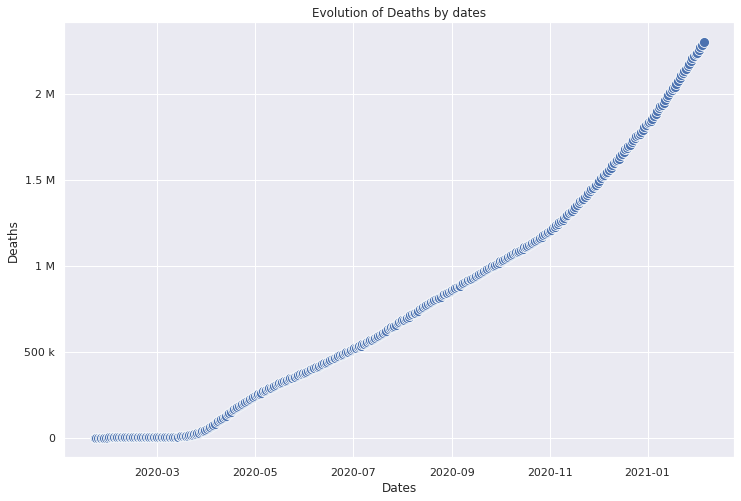

In [7]:
sns.set(style="darkgrid")    
fig, ax = plt.subplots(figsize=(12, 8))    
palette = sns.color_palette("bright", 4)
ax.yaxis.set_major_formatter(ticker.EngFormatter())
g = sns.scatterplot(data=dataset, ax=ax, x='ds', y="y", marker='o', s=100, palette= palette)
plt.xlabel('Dates')
plt.ylabel('Deaths')
plt.title('Evolution of Deaths by dates')

and let's see how the daily increase looks like. To do this, we will use the `diff` method from the Dataframe object.

In [8]:
dataset.diff()

,y
ds,
2020-01-22,NaN
2020-01-23,1.0
2020-01-24,8.0
2020-01-25,16.0
2020-01-26,14.0
...,...
2021-02-01,10218.0
2021-02-02,14936.0
2021-02-03,15733.0


In this project, we are going to analyze the daily reported deaths

Text(0.5, 1.0, 'Evolution of Daily Increases of Deaths by dates')

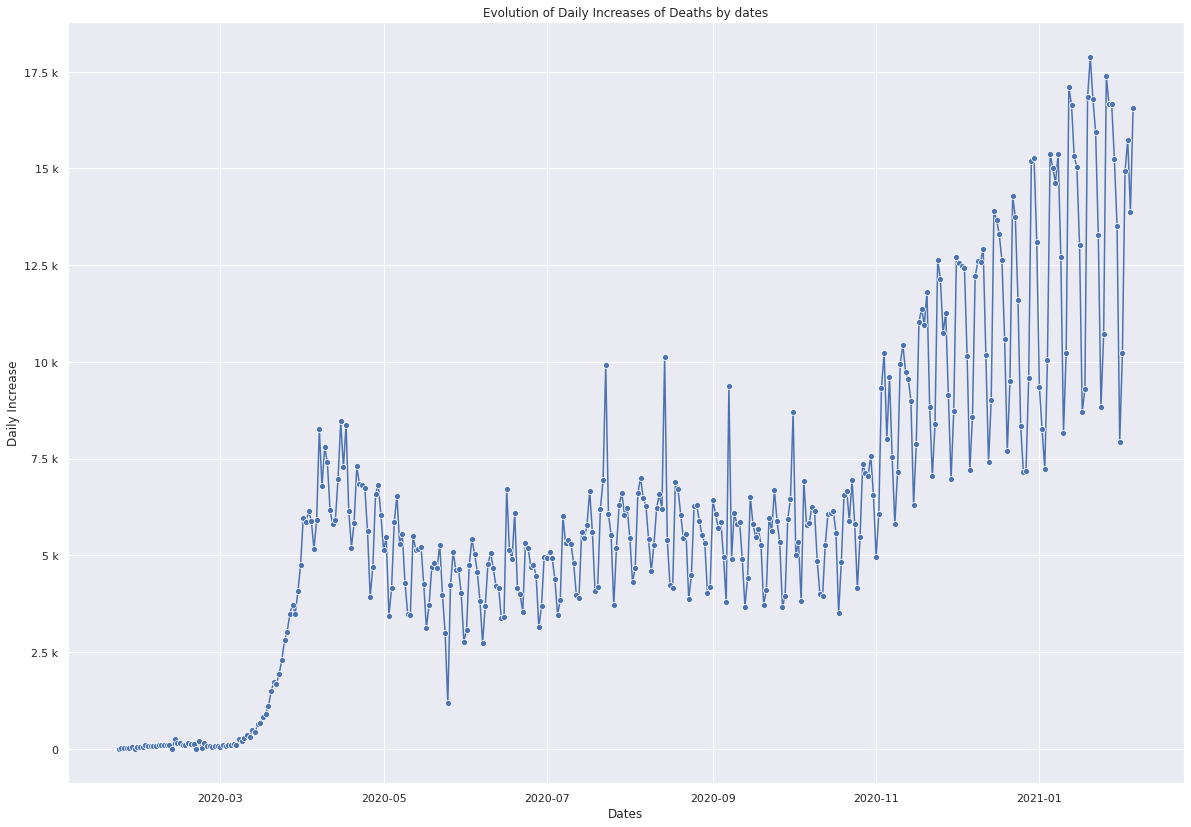

In [9]:
sns.set(style="darkgrid")    
fig, ax = plt.subplots(figsize=(20, 14))    
palette = sns.color_palette("bright", 4)
ax.yaxis.set_major_formatter(ticker.EngFormatter())
g = sns.lineplot(data=dataset.diff(), ax=ax, x='ds', y="y", marker='o', palette= palette)
plt.xlabel('Dates')
plt.ylabel('Daily Increase')
plt.title('Evolution of Daily Increases of Deaths by dates')

We need to remove the first data point here, which will be a None value

In [10]:
dataset = dataset.loc['2020-01-24':'2020-08-04']
# Get rid of NaN

In [11]:
dataset

,y
ds,
2020-01-24,26
2020-01-25,42
2020-01-26,56
2020-01-27,82
2020-01-28,131
...,...
2020-07-31,675838
2020-08-01,681296
2020-08-02,685599


# Forecasting using SARIMAX, or Seasonal AutoRegressive Integrated Moving Average with eXogenous regressors model

SARIMAX is one of the time series models in the python statistics library statsmodels.

In [12]:
start_date = '2020-06-30'
dataset = dataset.diff()
train = dataset.loc[dataset.index < pd.to_datetime(start_date)]
test = dataset.loc[dataset.index >= pd.to_datetime(start_date)]

There are three hyperparameters that go into the order tuple: p, q and d. Here we've used p=5, q=1 and d=9.

In [15]:
# Or you can grid search
p = d = q = range(0, 3)

pdq = list(itertools.product(p, d, q))

pdqs = [(x[0], x[1], x[2], 7) for x in list(itertools.product(p, d, q))]

In [16]:
# This will take time
def sarimax_gridsearch(ts, pdq, pdqs, maxiter=50, freq='M'):

    # Run a grid search with pdq and seasonal pdq parameters and get the best BIC value
    ans = []
    for comb in pdq:
        for combs in pdqs:
            try:
                mod = sm.tsa.statespace.SARIMAX(ts,order=comb,
                                                seasonal_order=combs,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False,
                                                freq=freq)

                output = mod.fit(maxiter=maxiter) 
                ans.append([comb, combs, output.bic])
               # print('SARIMAX {} x {}12 : BIC Calculated ={}'.format(comb, combs, output.bic))
            except:
                continue
            
    # Find the parameters with minimal BIC value

    # Convert into dataframe
    ans_df = pd.DataFrame(ans, columns=['pdq', 'pdqs', 'bic'])

    # Sort and return top 5 combinations
    ans_df = ans_df.sort_values(by=['bic'],ascending=True)[0:5]
    
    return ans_df

In [ ]:
sarimax_gridsearch(train, pdq, pdqs, freq='D')

In [13]:
model = SARIMAX(train, order=(5,1,9))

In [20]:
train.dropna(axis = 0, inplace = True)
train.isna().sum()

y    0
dtype: int64

Next, we call the fit method to optimize the model.

In [14]:
results = model.fit(disp=True)

Now let's make predictions using the model, and compare those against the values in the test set.

In [15]:
sarimax_prediction = results.predict(
    start=start_date, end='2020-07-30', dynamic=False)

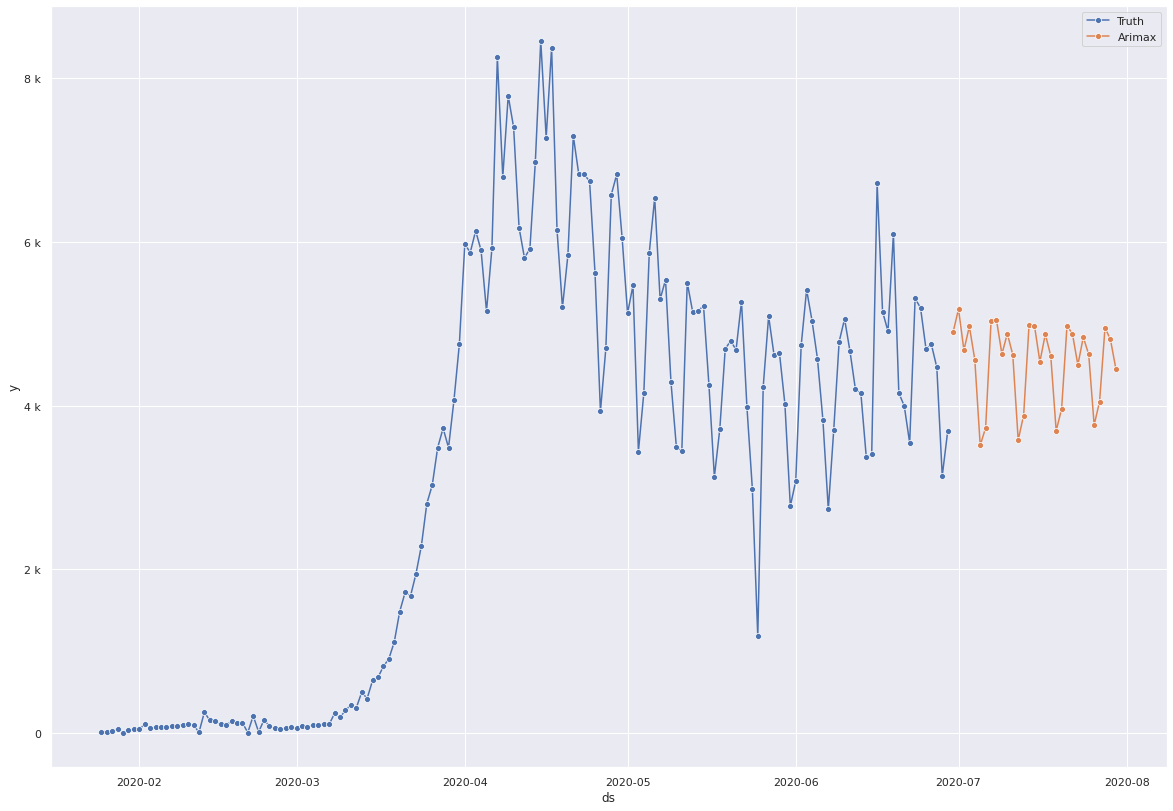

In [17]:
sarimax_prediction_df = sarimax_prediction.to_frame() 

sns.set(style="darkgrid")    
fig, ax = plt.subplots(figsize=(20, 14))    
palette = sns.color_palette("bright", 4)
ax.yaxis.set_major_formatter(ticker.EngFormatter())
sns.lineplot(data=train, ax=ax, x='ds', y="y", marker='o', palette= palette, label = 'Truth')
sns.lineplot(data=sarimax_prediction_df, ax=ax, x = sarimax_prediction_df.index, y="predicted_mean", marker='o', palette= palette,
             label = 'Arimax')
plt.legend()

However, in a typical machine learning workflow, we should find the best values of p, q and r that will minimize the error. We can use the auto_arima function in the pmdarima module to do that. This will find the optimal parameter combintation and return the best model.


In [21]:
model = pm.auto_arima(train, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3,  # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0,
                      D=0,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2537.079, Time=0.33 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2548.743, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2550.188, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2549.677, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2546.867, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2528.826, Time=0.33 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=2543.675, Time=0.04 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=2527.360, Time=0.41 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=2541.155, Time=0.07 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=2531.572, Time=0.41 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=2481.046, Time=0.55 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2532.397, Time=0.43 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=2470.738, Time=0.76 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=2514.182, Time=0.52 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept

Note that this gives us the best mode here: "Best model:  SARIMAX(2,1,3)(0,0,0)[0]"

In [22]:
model = SARIMAX(train, order=(2,1,3))

Next, we call the fit method to optimize the model.

In [23]:
results = model.fit(disp=True)

Now let's make predictions using the model, and compare those against the values in the test set.

In [24]:
sarimax_prediction = results.predict(
    start=start_date, end='2020-07-30', dynamic=False)

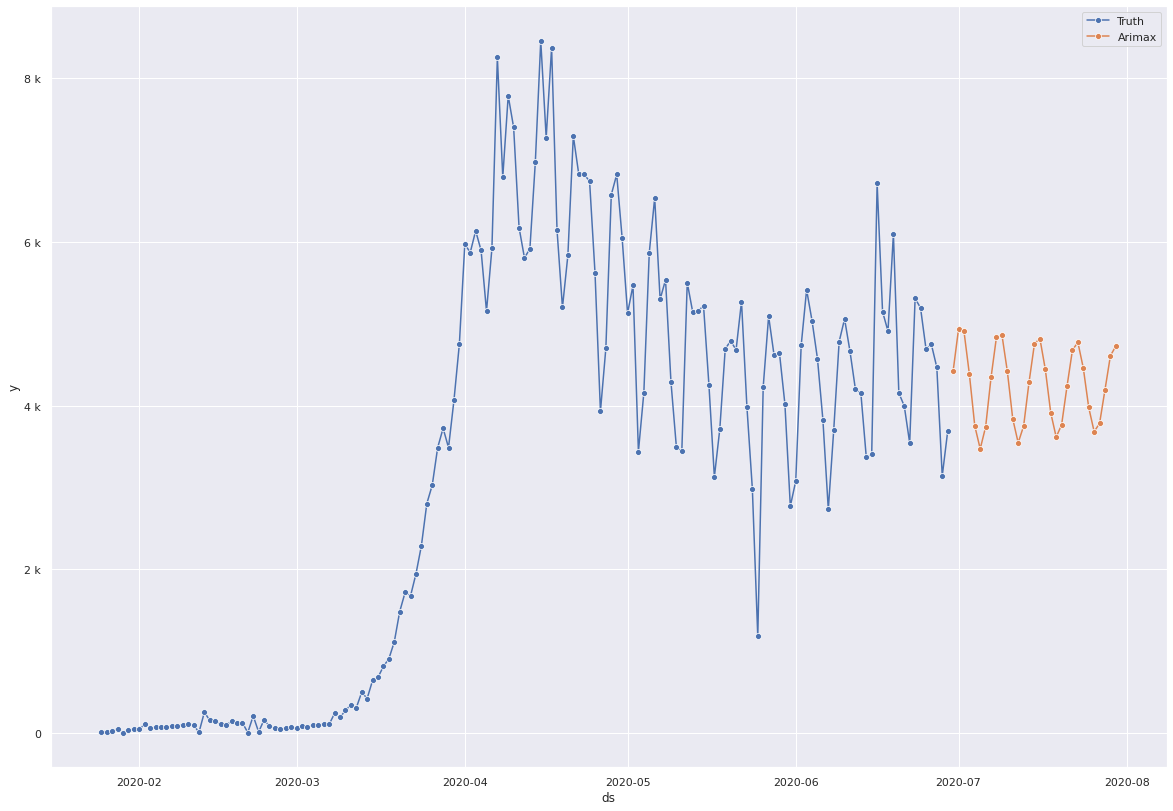

In [25]:
sarimax_prediction_df = sarimax_prediction.to_frame() 

sns.set(style="darkgrid")    
fig, ax = plt.subplots(figsize=(20, 14))    
palette = sns.color_palette("bright", 4)
ax.yaxis.set_major_formatter(ticker.EngFormatter())
sns.lineplot(data=train, ax=ax, x='ds', y="y", marker='o', palette= palette, label = 'Truth')
sns.lineplot(data=sarimax_prediction_df, ax=ax, x = sarimax_prediction_df.index, y="predicted_mean", marker='o', palette= palette,
             label = 'Arimax')
plt.legend()

# Forecasting using Facebook's Prophet model

Prophet expects the data frame to have 2 columns, unlike SARIMAX.

In [26]:
train['ds'] = train.index.values

Then we create a new Prophet object and call the `fit()` method

In [27]:
m = Prophet()
m.fit(train)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Now let's forecast:

In [28]:
future = m.make_future_dataframe(periods=dataset.shape[0]-train.shape[0])
prophet_prediction = m.predict(future)

In [31]:
future

,ds
0,2020-01-25
1,2020-01-26
2,2020-01-27
3,2020-01-28
4,2020-01-29
...,...
189,2020-08-01
190,2020-08-02
191,2020-08-03
192,2020-08-04


In [32]:
prophet_prediction

,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
ds,,,,,,,,,,,,,,,
2020-01-25,-1223.575372,-2917.263940,262.241465,-1223.575372,-1223.575372,-141.364714,-141.364714,-141.364714,-141.364714,-141.364714,-141.364714,0.0,0.0,0.0,-1364.940087
2020-01-26,-1149.641976,-3592.460271,-257.482136,-1149.641976,-1149.641976,-762.820830,-762.820830,-762.820830,-762.820830,-762.820830,-762.820830,0.0,0.0,0.0,-1912.462806
2020-01-27,-1075.708579,-3335.996312,-4.197145,-1075.708579,-1075.708579,-620.526765,-620.526765,-620.526765,-620.526765,-620.526765,-620.526765,0.0,0.0,0.0,-1696.235344
2020-01-28,-1001.775182,-2186.707052,1123.687002,-1001.775182,-1001.775182,427.762684,427.762684,427.762684,427.762684,427.762684,427.762684,0.0,0.0,0.0,-574.012498
2020-01-29,-927.841786,-2038.404883,1167.614048,-927.841786,-927.841786,485.200996,485.200996,485.200996,485.200996,485.200996,485.200996,0.0,0.0,0.0,-442.640789
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-01,4485.821620,2707.430745,5923.251745,4260.032251,4725.903796,-141.364714,-141.364714,-141.364714,-141.364714,-141.364714,-141.364714,0.0,0.0,0.0,4344.456906
2020-08-02,4481.165938,2149.710560,5327.442429,4242.815549,4734.563952,-762.820830,-762.820830,-762.820830,-762.820830,-762.820830,-762.820830,0.0,0.0,0.0,3718.345108
2020-08-03,4476.510256,2225.658590,5388.788020,4231.182495,4740.664069,-620.526765,-620.526765,-620.526765,-620.526765,-620.526765,-620.526765,0.0,0.0,0.0,3855.983491


Next, let's visualize the predictions.

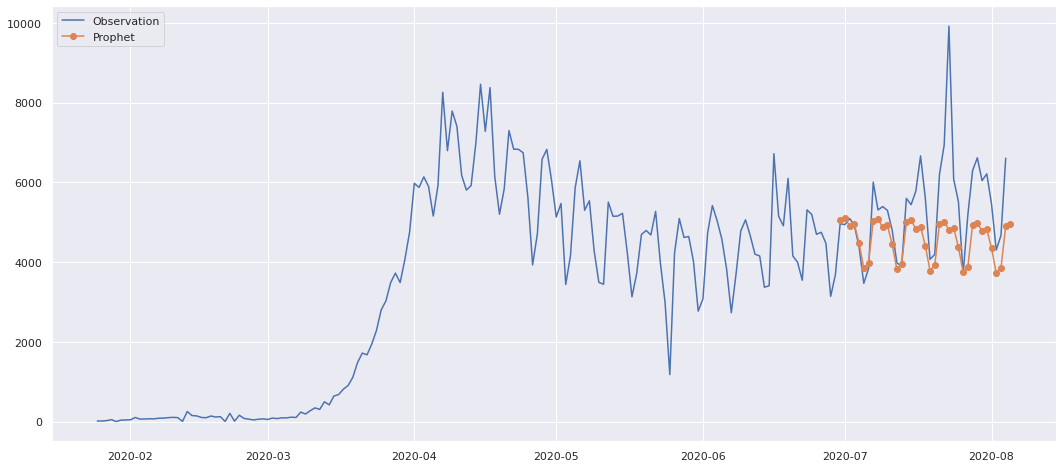

In [35]:
plt.figure(figsize=(18, 8))
plt.plot(dataset, label='Observation')
plt.plot(prophet_future, label='Prophet',marker = 'o')
plt.savefig('Prophet predictions',
            bbox_inches='tight', transparent=False)
plt.legend()